# DYN model & Test

By _Alessandro Liberatore_ (INAF-OATo)

Python Notebook to follow up and reproduce the Lemaire, Stegen, and Katsiyannis articles (see following references) where they introduced their DYN method (i.e., hydrodynamic equilibrium method) to calculate coronal temperature profiles from given radial distributions of the coronal solar wind (SW) and electron densities ($n_e$).

---

References:

- \[REF_1\]: Joseph F. Lemaire and K. Stegen, Solar Phys (2016) 291:3659–3683; DOI [10.1007/s11207-016-1001-32016](https://link.springer.com/article/10.1007/s11207-016-1001-3).

- \[REF_2\]: Joseph F. Lemaire and Athanassios C. Katsiyannis, Solar Physics (2021) 296:64; DOI [10.1007/s11207-021-01814-4](https://link.springer.com/article/10.1007/s11207-021-01814-4).

---

### Libraries

In [2]:
#%matplotlib notebook

from astropy import units as u
from astropy.constants import R_sun
from astropy.constants import au

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

from scipy.integrate import quad
from mpmath import quad, inf

from sympy import *
import sympy as sp

### Useful Constants

Solar radius ($R_\odot$) and Astronomical Unit (AU):

In [3]:
# Solar Radius

Rsun_cm = R_sun.to(u.cm).value  # Solar radius in centimeters (float)
Rsun_m = R_sun.value            # Solar radius in meters (float)
Rsun_km = R_sun.to(u.km).value  # Solar radius in kilometers (float)

print(f"| Solar radius in centimeters: {Rsun_cm} cm")
print(f"| Solar radius in meters: {Rsun_m} m")
print(f"| Solar radius in kilometers: {Rsun_km} km")


print("-"*50) # --------------------------------------------------


# Astronomical Unit

AU_cm = au.to(u.cm).value  # AU in centimeters (float)
AU_m = au.value            # AU in meters (float)
AU_km = au.to(u.km).value  # AU in kilometers (float)

print(f"| Astronomical Unit in centimeters: {AU_cm} cm")
print(f"| Astronomical Unit in meters: {AU_m} m")
print(f"| Astronomical Unit in kilometers: {AU_km} km")

| Solar radius in centimeters: 69570000000.0 cm
| Solar radius in meters: 695700000.0 m
| Solar radius in kilometers: 695700.0 km
--------------------------------------------------
| Astronomical Unit in centimeters: 14959787070000.0 cm
| Astronomical Unit in meters: 149597870700.0 m
| Astronomical Unit in kilometers: 149597870.70000002 km


We will consider latitudes = 0 deg (i.e., equatorial) and latitudes = 90 deg (i.e., polar):

In [4]:
# Different row = different test
latitude = [0*np.pi/180, 90*np.pi/180, 
            0*np.pi/180, 0*np.pi/180, 0*np.pi/180, 0*np.pi/180, 
            90*np.pi/180, 90*np.pi/180, 90*np.pi/180, 90*np.pi/180]

Electron density and solar wind velocity at 1 AU \[see 'Seq' and 'Spv' rows in Table 1, REF_1\]:

In [5]:
# Electron density at 1AU -------------------------

# Test n.0 Equatorial vs Polar (see the antepenultimate plot of this notebook) 
nE_equatorial = 5.75  # [cm^-3]
nE_polar = 2.22       # [cm^-3]

# Test n.1 different Equatorial nE (see the penultimate plot of this notebook) 
nE_0 = 5.75  # [cm^-3]
nE_1 = 1     # [cm^-3]
nE_2 = 30    # [cm^-3]
nE_3 = 5.75  # [cm^-3]

# Test n.2 different Polar nE (see the last plot of this notebook) 
nE_4 = 2.22  # [cm^-3]
nE_5 = 2.22  # [cm^-3]
nE_6 = 2.22  # [cm^-3]
nE_7 = 2.22  # [cm^-3]

nE = [nE_equatorial, nE_polar, nE_0, nE_1, nE_2, nE_3, nE_4, nE_5, nE_6, nE_7]


# Solar wind at 1AU -------------------------

# Test n.0 Equatorial vs Polar (see the antepenultimate plot of this notebook) 
uE_equatorial = 3.29e7  # [cm/s]
uE_polar = 3.29e7       # [cm/s]

# Test n.1 different Equatorial SW (see the penultimate plot of this notebook) 
uE_0 = 3.29e7  # [cm/s]
uE_1 = 3.29e7  # [cm/s]
uE_2 = 3.29e7  # [cm/s]
uE_3 = 6.00e7  # [cm/s]

# Test n.2 different Polar SW (see the last plot of this notebook) 
uE_4 = 1.00e5  # [cm/s]
uE_5 = 1.00e7  # [cm/s]
uE_6 = 3.29e7  # [cm/s]
uE_7 = 4.50e7  # [cm/s]

uE = [uE_equatorial, uE_polar, uE_0, uE_1, uE_2, uE_3, uE_4, uE_5, uE_6, uE_7]

Let's define the main variables

In [6]:
r = symbols('r')
phi = symbols('phi')

### Electron density profiles

<u>Equation 1</u> \[i.e., Eq. (7) in REF_1; Eq. (1) in REF_2\], from Saito, [1970](https://ui.adsabs.harvard.edu/abs/1970AnTok..12...53S/abstract):

In [7]:
h_values = np.linspace(0.01, 10, 1000)  # altitude above photosphere in solar radius unit

ne = []
ne_values = []
for lat in range(len(latitude)):
    ne_singleLat = 10**8 * (3.09 * r**(-16) * (1 - 0.5 * sin(phi)) 
         + 1.58 * r**(-6) * (1 - 0.95 * sin(phi))
         + 0.0251 * r**(-2.5) * (1 - sqrt(sin(phi)))) + nE[lat] * (215/r)**2
    ne.append(ne_singleLat.subs(phi, latitude[lat]))
    ne_values.append([ne[lat].subs(r, h+1) for h in h_values])
    #print("ne_values[{0}]:\n{1}\n".format(lat, ne_values[lat]))

Note: the electron density $n_e$ is function of $r$ (i.e., heliocentric distance in solar radius unit), not $h$ (i.e., altitude above photosphere in solar radius unit). A change of variable is needed if we want to plot $n_e$ in function of $h$. In particular, we must run $n_e(h+1, \varphi, n_E)$ instead of $n_e(r, \varphi, n_E)$.

Plot of electron densities profiles (log-scale is used for $h$, which is measured in solar radius unit, $R_\odot = 696 \text{Mm}$, between 0.01$R_\odot$ and 10$R_\odot$ above the photosphere, for a fixed latitude $\varphi$). The minimum $h = 0.01 R_\odot = 6.96 \text{Mm}$ is still three times higher than the altitude of the transition region between the chromosphere and the corona.

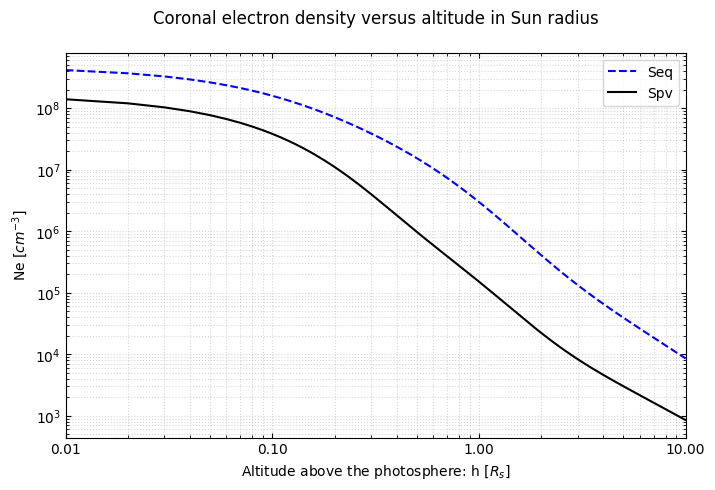

In [8]:
plt.figure(figsize=(8, 5))

# Plot
plt.plot(h_values, ne_values[0], "--", label='Seq', color = "blue")
plt.plot(h_values, ne_values[1], "-", label='Spv', color = "black")

# Cosmetic
plt.title("Coronal electron density versus altitude in Sun radius\n")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Altitude above the photosphere: h [$R_s$]")
plt.ylabel("Ne [$cm^{-3}$]")
plt.tick_params(direction="in", which="both", top = "True", right = "True")
plt.grid(True, which="both", linestyle=":", alpha = 0.5)

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain', axis='x')

plt.xlim(0.01,10)

# Legend
plt.legend()
plt.rcParams['figure.dpi'] = 600  # set the image resolution at 600 DPI

### Radial velocities

Equation 1 can be used to derive an analytical expression for the SW bulk velocity, $u(r)$, by integrating the continuity equation -the conservation of the particle flux- from the Earth’s radial distance ($r_E$) down to the base of the corona ($r_b$), where $r_b$ is defined hereafter to be at 1.003$R_\odot$.

In the following model this integration is performed along flow tubes whose geometrical cross-section, $A(r)$ is an empirical function of $r$ (obtained following Kopp and Holzer, [1976](https://link.springer.com/article/10.1007/BF00221484)). The mathematical formula used for $A(r)$ can be found in REF_1, Eq. (12):

$$\frac{A(r)}{A(1)} = r^2 f(r) = r^2 \frac{f_{\text{max}}\exp\left(\frac{r - r_1}{\sigma}\right) + f_1}{\exp\left(\frac{r - r_1}{\sigma}\right) + 1}$$

where $f_{\text{max}}$ is the maximum radial expansion factor, or the minimum constriction factor; $r_1$ is the heliocentric distance of the steepest expansion rate; $\sigma$ is the normalized range of altitudes over which this steepest expansion/constriction rate is centered; $f_1 = 1 + (1 − f_{\text{max}}) \exp[(1 − r_1)/\sigma]$; and $f(1) = 1$ at the surface of the Sun. The values of all these parameters are reported in Table 1 of REF_1.

We restrict our DYN model calculations to spherical expansions of the SW, i.e., $A_E /A(r) = (215/r)^2$ as done in REF_2 (see Page 3 of 12), where $A_E$ is the cross-section of the flow tube at $1 \text{AU}$. 

We have assumed, like most other modelers of the SW, that flow tubes of the plasma coincide with interplanetary magnetic flux tubes \[REF_1, REF_2\].

<u>Equation 2</u> \[i.e., Eq. (13) in REF_1; Eq. (2) in REF_2\]:

In [9]:
u = []
u_values = []
for lat in range(len(latitude)):
    AE_Ar = (215/r)**2
    u_singleLat = uE[lat] * AE_Ar * nE[lat] / ne[lat]
    u.append(u_singleLat.subs(phi, latitude[lat]))
    u_values.append([u[lat].subs(r, h+1) for h in h_values])
    #print("u_values[{0}]:\n{1}\n".format(lat, u_values[lat]))

We will need to evaluate $du/dr$ (see Equation 3 below). The derivative of $u(r)$ is:

In [10]:
du_dr = []
du_dr_values = []
for lat in range(len(latitude)):
    du_dr_singleLat = sp.diff(u[lat], r)
    du_dr.append(du_dr_singleLat)
    du_dr_values.append([du_dr[lat].subs(r, h+1) for h in h_values])
    #print("du/dr_values[{0}]:\n{1}\n".format(lat, du_dr_values[lat]))

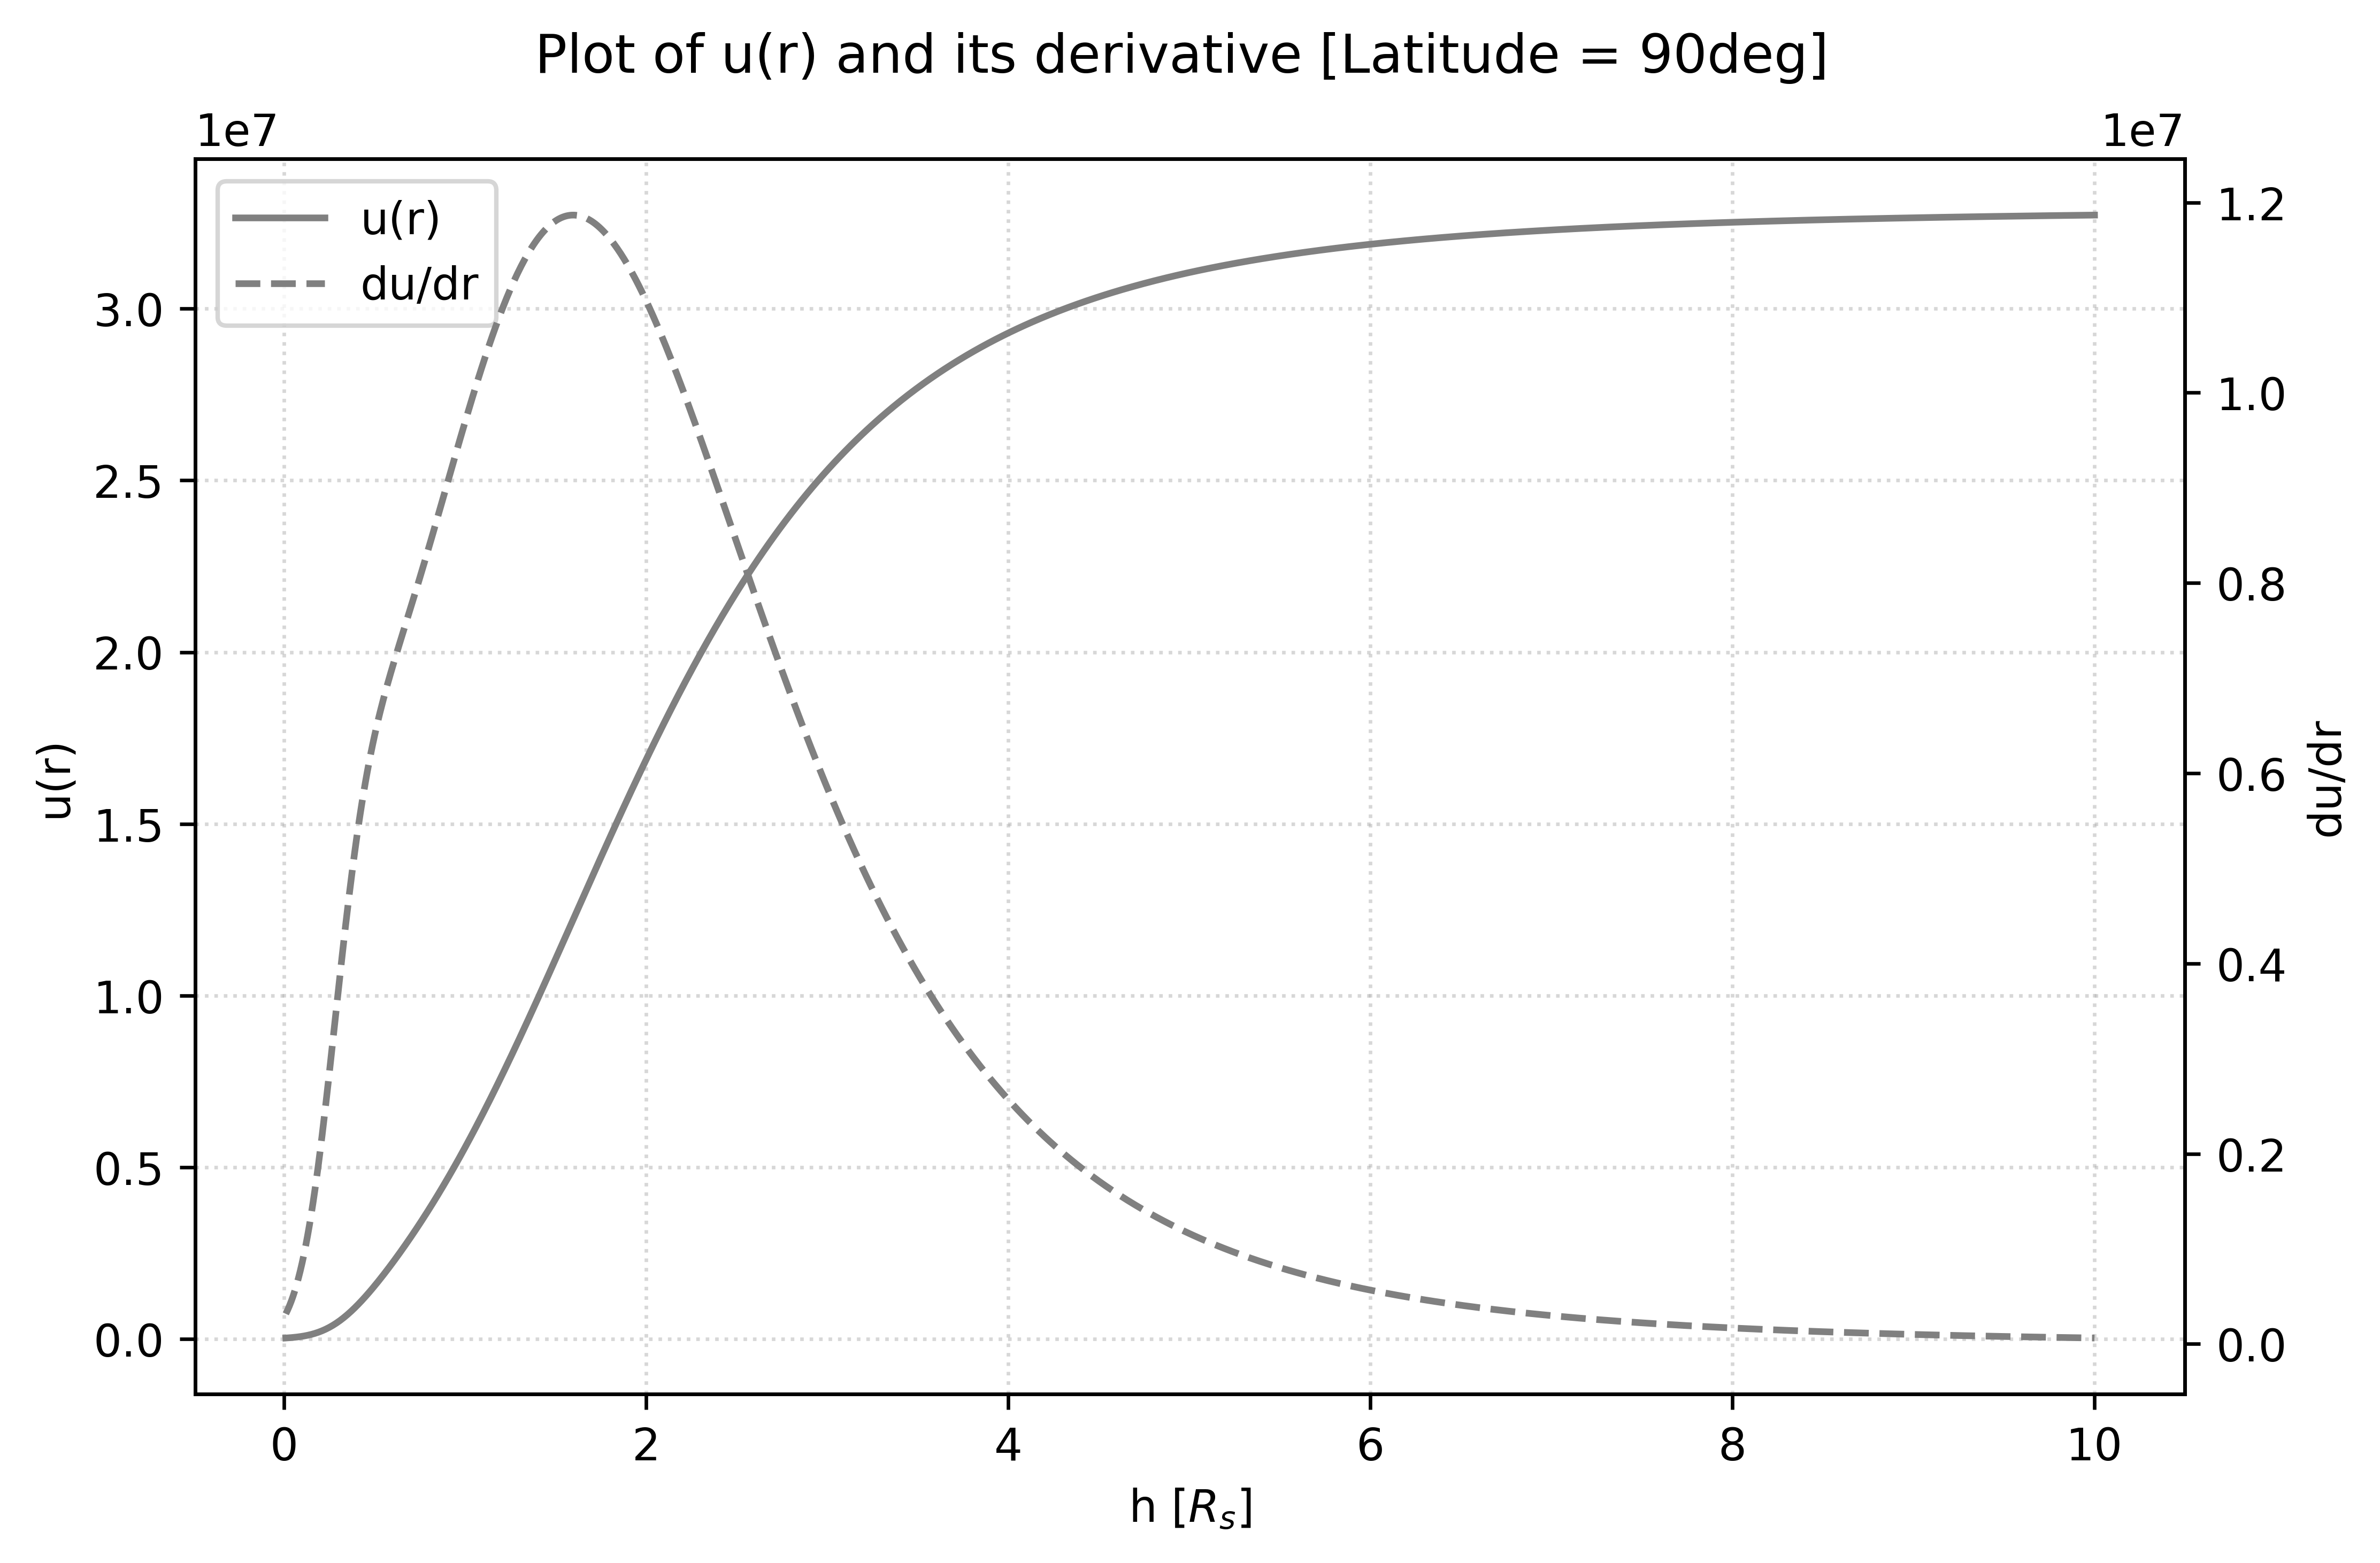

In [11]:
# E.g., plot of u(r) with polar values, and its derivative
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot
line1, = ax1.plot(h_values, u_values[1], "-", label='u(r)', color = "gray")
ax2 = ax1.twinx()
line2, = ax2.plot(h_values, du_dr_values[1], "--", label='du/dr', color = "gray")

ax1.set_xlabel('h [$R_s$]')
ax1.set_ylabel('u(r)')
ax2.set_ylabel('du/dr')

ax1.set_title('Plot of u(r) and its derivative [Latitude = 90deg] \n')
ax1.grid(True, which="both", linestyle=":", alpha = 0.5)
#ax2.grid(True, which="both", linestyle=":", alpha = 0.5)

lines = [line1, line2]
ax1.legend(lines, [line.get_label() for line in lines], loc='upper left')
plt.rcParams['figure.dpi'] = 600  # set the image resolution at 600 DPI

Equations 1 and 2 allow the straightforward calculation of the dimensionless function $F(r)$, corresponding to the ratio of the inertial force and the gravitation force acting on the expanding SW plasma.

Considering the gravitational acceleration at the solar surface $g_S$ [Page 6 of 25 in REF_1, and Page 3 of 12 in REF_2]:

In [12]:
gS = 2.74e4  # [cm/s^2]

$F(r)$ can be defined as the following <u>Equation 3</u> \[i.e., Eq. (15) in REF_1; Eq. (3) in REF_2\] :

In [13]:
F = []
F_values = []
for lat in range(len(latitude)):
    F_singleLat = (1 / (gS * Rsun_cm)) * r**2 * u[lat] * du_dr[lat]
    F.append(F_singleLat)
    F_values.append([F[lat].subs(r, h+1) for h in h_values])
    #print("F_values[{0}]:\n{1}\n".format(lat, F_values[lat]))

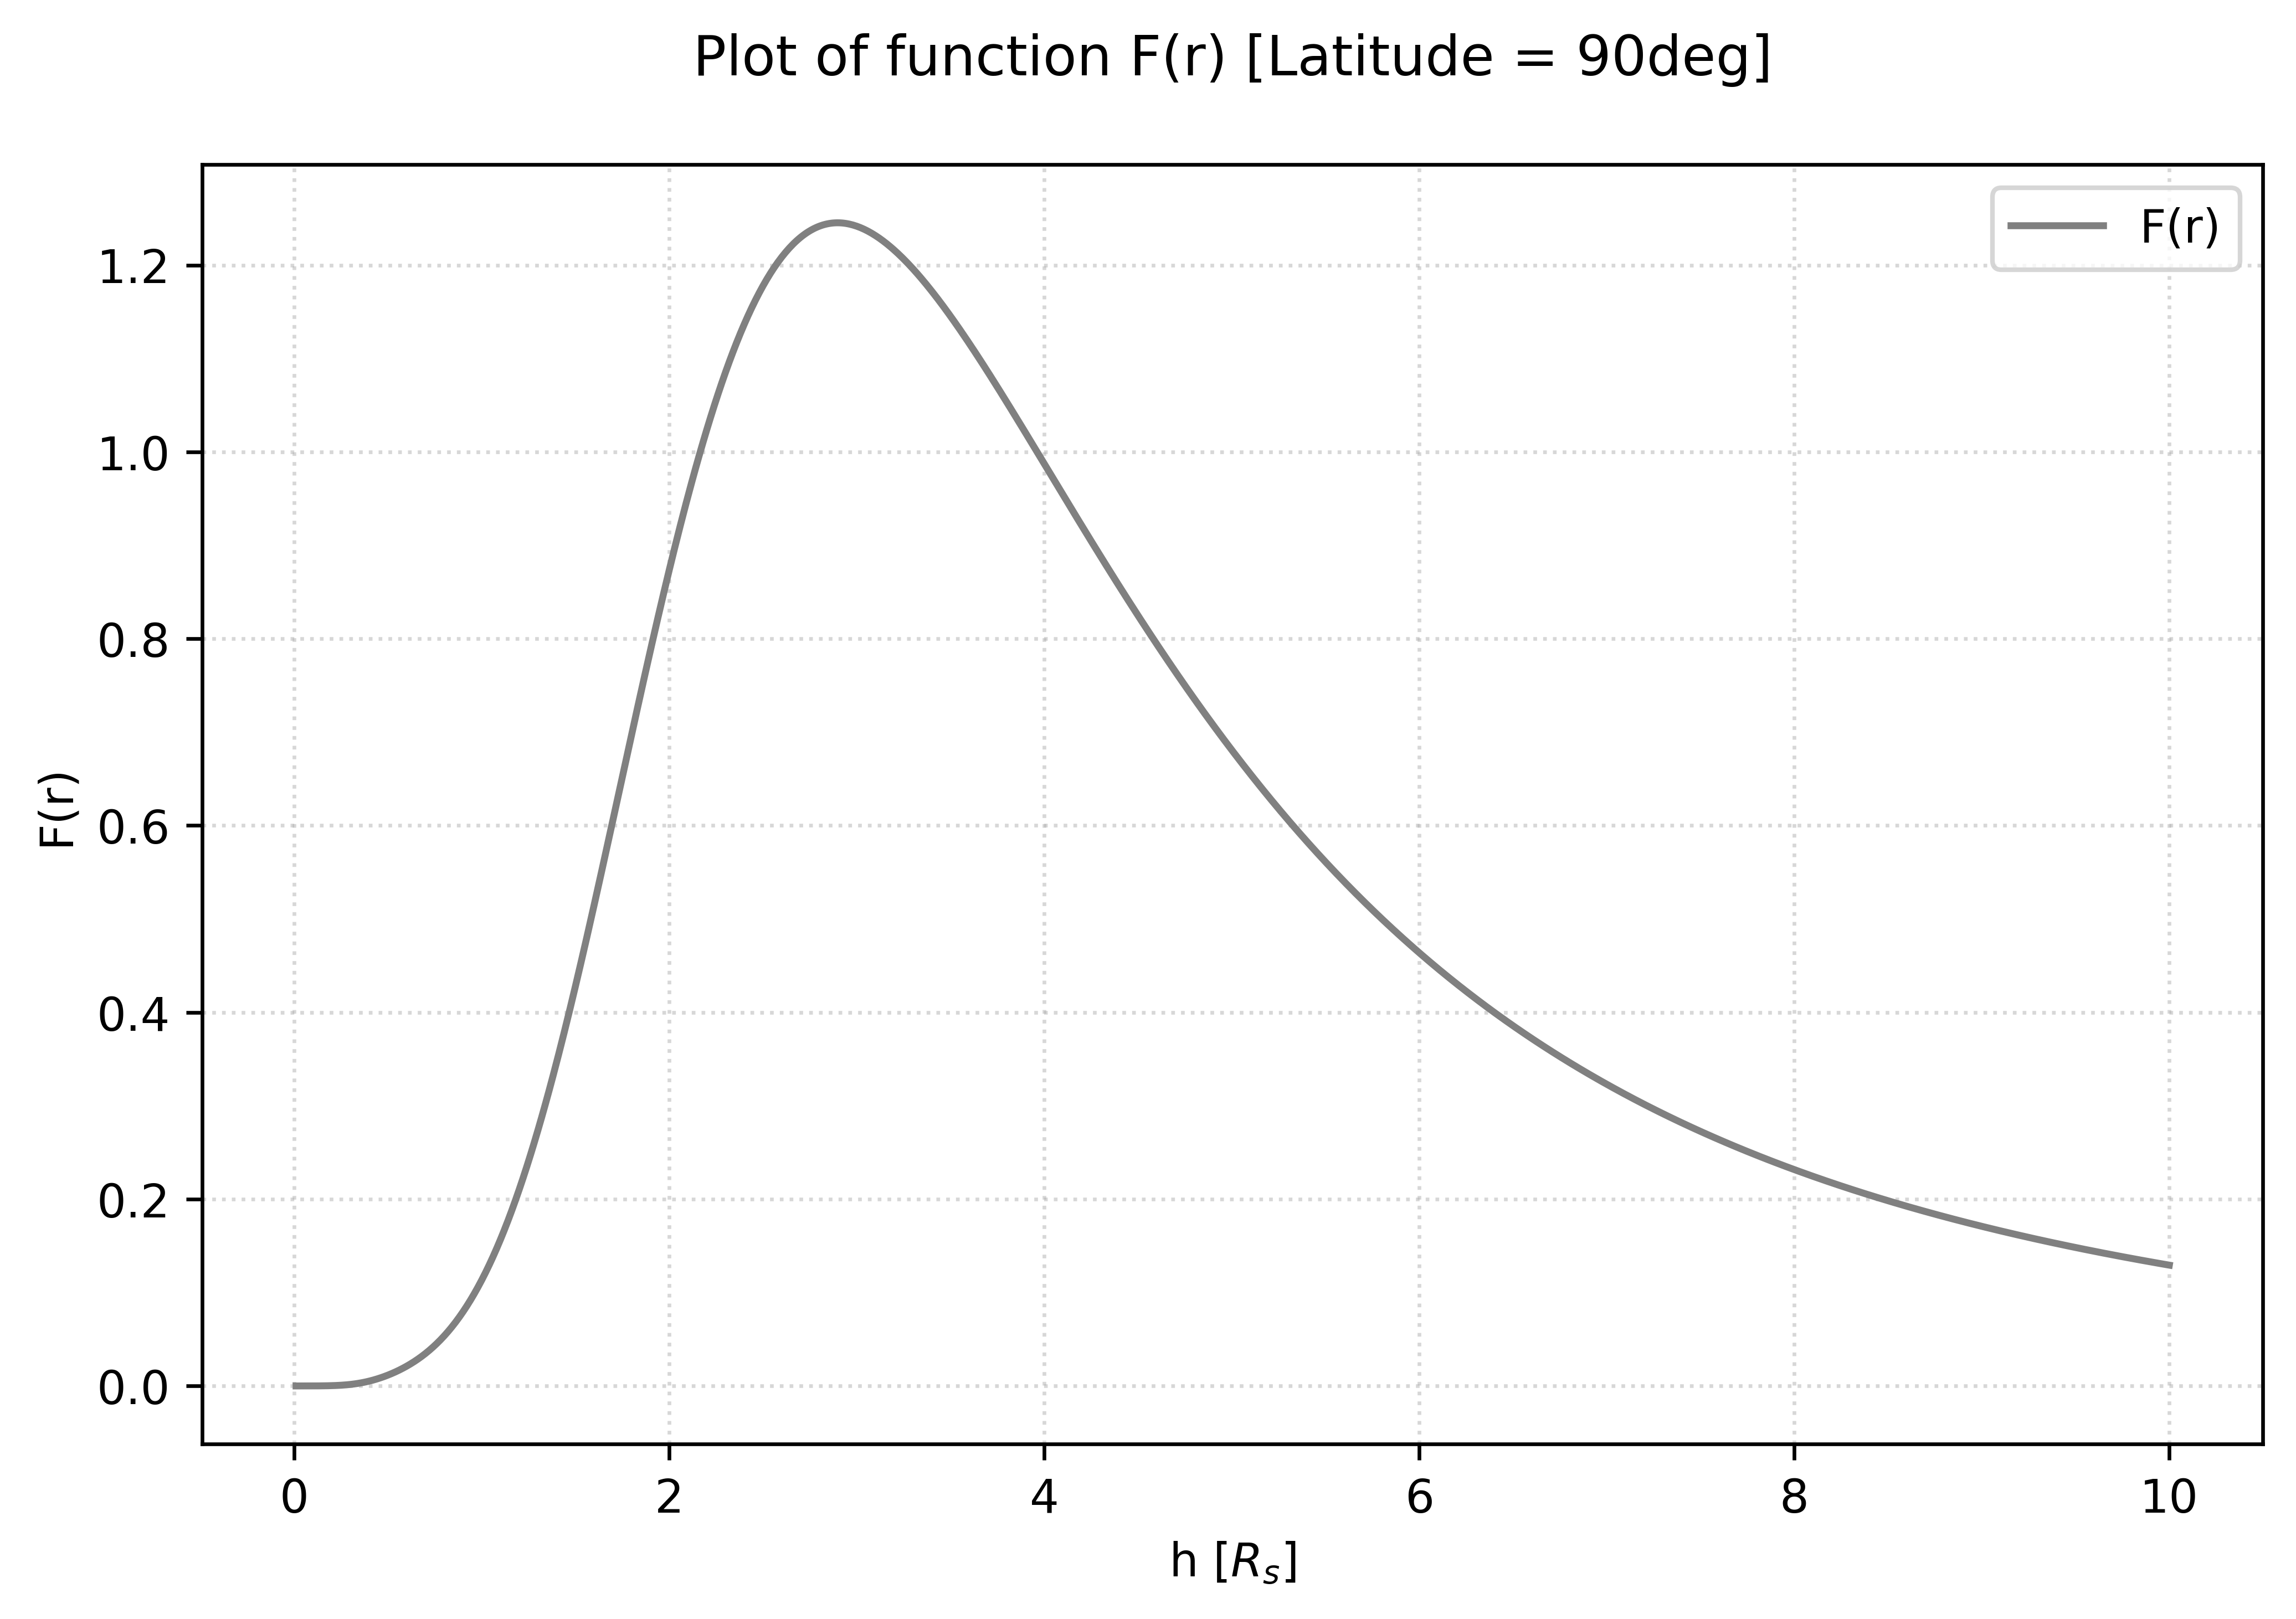

In [16]:
# E.g., plot of F(r) with polar values
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(h_values, F_values[1], "-", label='F(r)', color = "gray")

ax1.set_xlabel('h [$R_s$]')
ax1.set_ylabel('F(r)')

ax1.set_title('Plot of function F(r) [Latitude = 90deg]\n')
ax1.grid(True, which="both", linestyle=":", alpha = 0.5)
ax1.legend()
plt.rcParams['figure.dpi'] = 600  # set the image resolution at 600 DPI

### Coronal temperature profiles

To obtain the radial distribution of the DYN temperature, \[REF_1\] integrated the simplest approximation of hydrodynamic momentum transport equation, from infinity (where they assumed that the plasma temperature is equal to zero), down to $r_b$, the base of the corona. \[REF_1\] introduces also a normalization temperature $T^*$ \[see Eq. (28) therein, Page 23 of 25\] based on Alfvén, [1941](https://ui.adsabs.harvard.edu/abs/1941ArMAF..27A...1A/abstract):

In [15]:
# Normalization temperature

mu = 0.5           # Ratio mi/mp (if the gas is fully ionized hydrogen) [see Page 6 of 25 in REF_1]
mH = 1.67e-27      # Mass of hydrogen atom [kg]
kb = 1.380649e-19  # Boltzmann constant [cm^2 kg / s^2 K]

T_star = mu*gS*Rsun_cm*mH/kb  # = 1.15e+07 K
#T_star = 13e6  # K [i.e., Ref_1]
#T_star = 17e6  # K [i.e., Ref_2]
print("T* = {0:.2e} K".format(T_star))

T* = 1.15e+07 K


Here, $G$ is the gravitational constant; $2kT^∗$ corresponds to the gravitational potential energy of a mass ($m_H$) at the surface of the Sun, whose radius is $R_\odot$ and $M_\odot$ its mass. $T^*$ must be considered here as a normalizing factor. Note that this constant (= $13\text{MK}$ in \[REF_1, Page 10 of 25\], and $17\text{MK}$ in \[REF_2, Page 4 of 12\]) is of the same order of magnitude as the central temperature of the Sun.

Then, the coronal temperature profiles for a fixed latitude $\varphi$ can be obtained from the following equation (i.e., `T_singleLat`):

$$T_e = - \frac{T^*}{n_e(r)} \int_\infty^r{\frac{n_e(r)}{r^2}[1 + F(r)]}\hspace{1mm}\text{dr}$$

<u>Equation 4</u> \[i.e., Eq. (16) in REF_1; Eq. (4) in REF_2\]:

In [16]:
T_differentLat = []

for lat in range(len(latitude)):

    integrand = (ne[lat] / r**2) * (1 + F[lat])
    func = sp.lambdify(r, integrand, modules='scipy')
    T_singleLat = [-float(quad(func, [inf, r_extreme+1])) * T_star/float(ne[lat].subs(r,r_extreme+1)) for r_extreme in h_values]

    T_differentLat.append(T_singleLat)

`T_differentLat` contains the array with radial steps and values for coronal temperature plot for a fixed latitude $\varphi$ (we will plot the profiles between 0.01$R_\odot$ and 10$R_\odot$ above the photosphere).

Note: A non-zero additive constant temperature, $T_\infty$, corresponding to the actual electron temperature at the outer edge of the heliosphere could have been added to the right-hand side of Equation 4. However, the addition of a constant temperature of the order of $2000-3000 \text{K}$ does not change considerably the DYN temperature profile close to the Sun, indeed $T_e(r)$ is orders of magnitude larger for $r_b < r < 10 R_\odot$ than $T_\infty$. Therefore, it is not far from reality to set $T_\infty = 0$.

Plot of coronal temperature profiles. Is it possible to compare the profiles with the ones in Figure 4 in \[REF_1\], or the polar profile with the one in Figure 2 in \[REF_2\] (both in red) and the equatorial profile with the one in Figure 3 in \[REF_2\] (both in black).

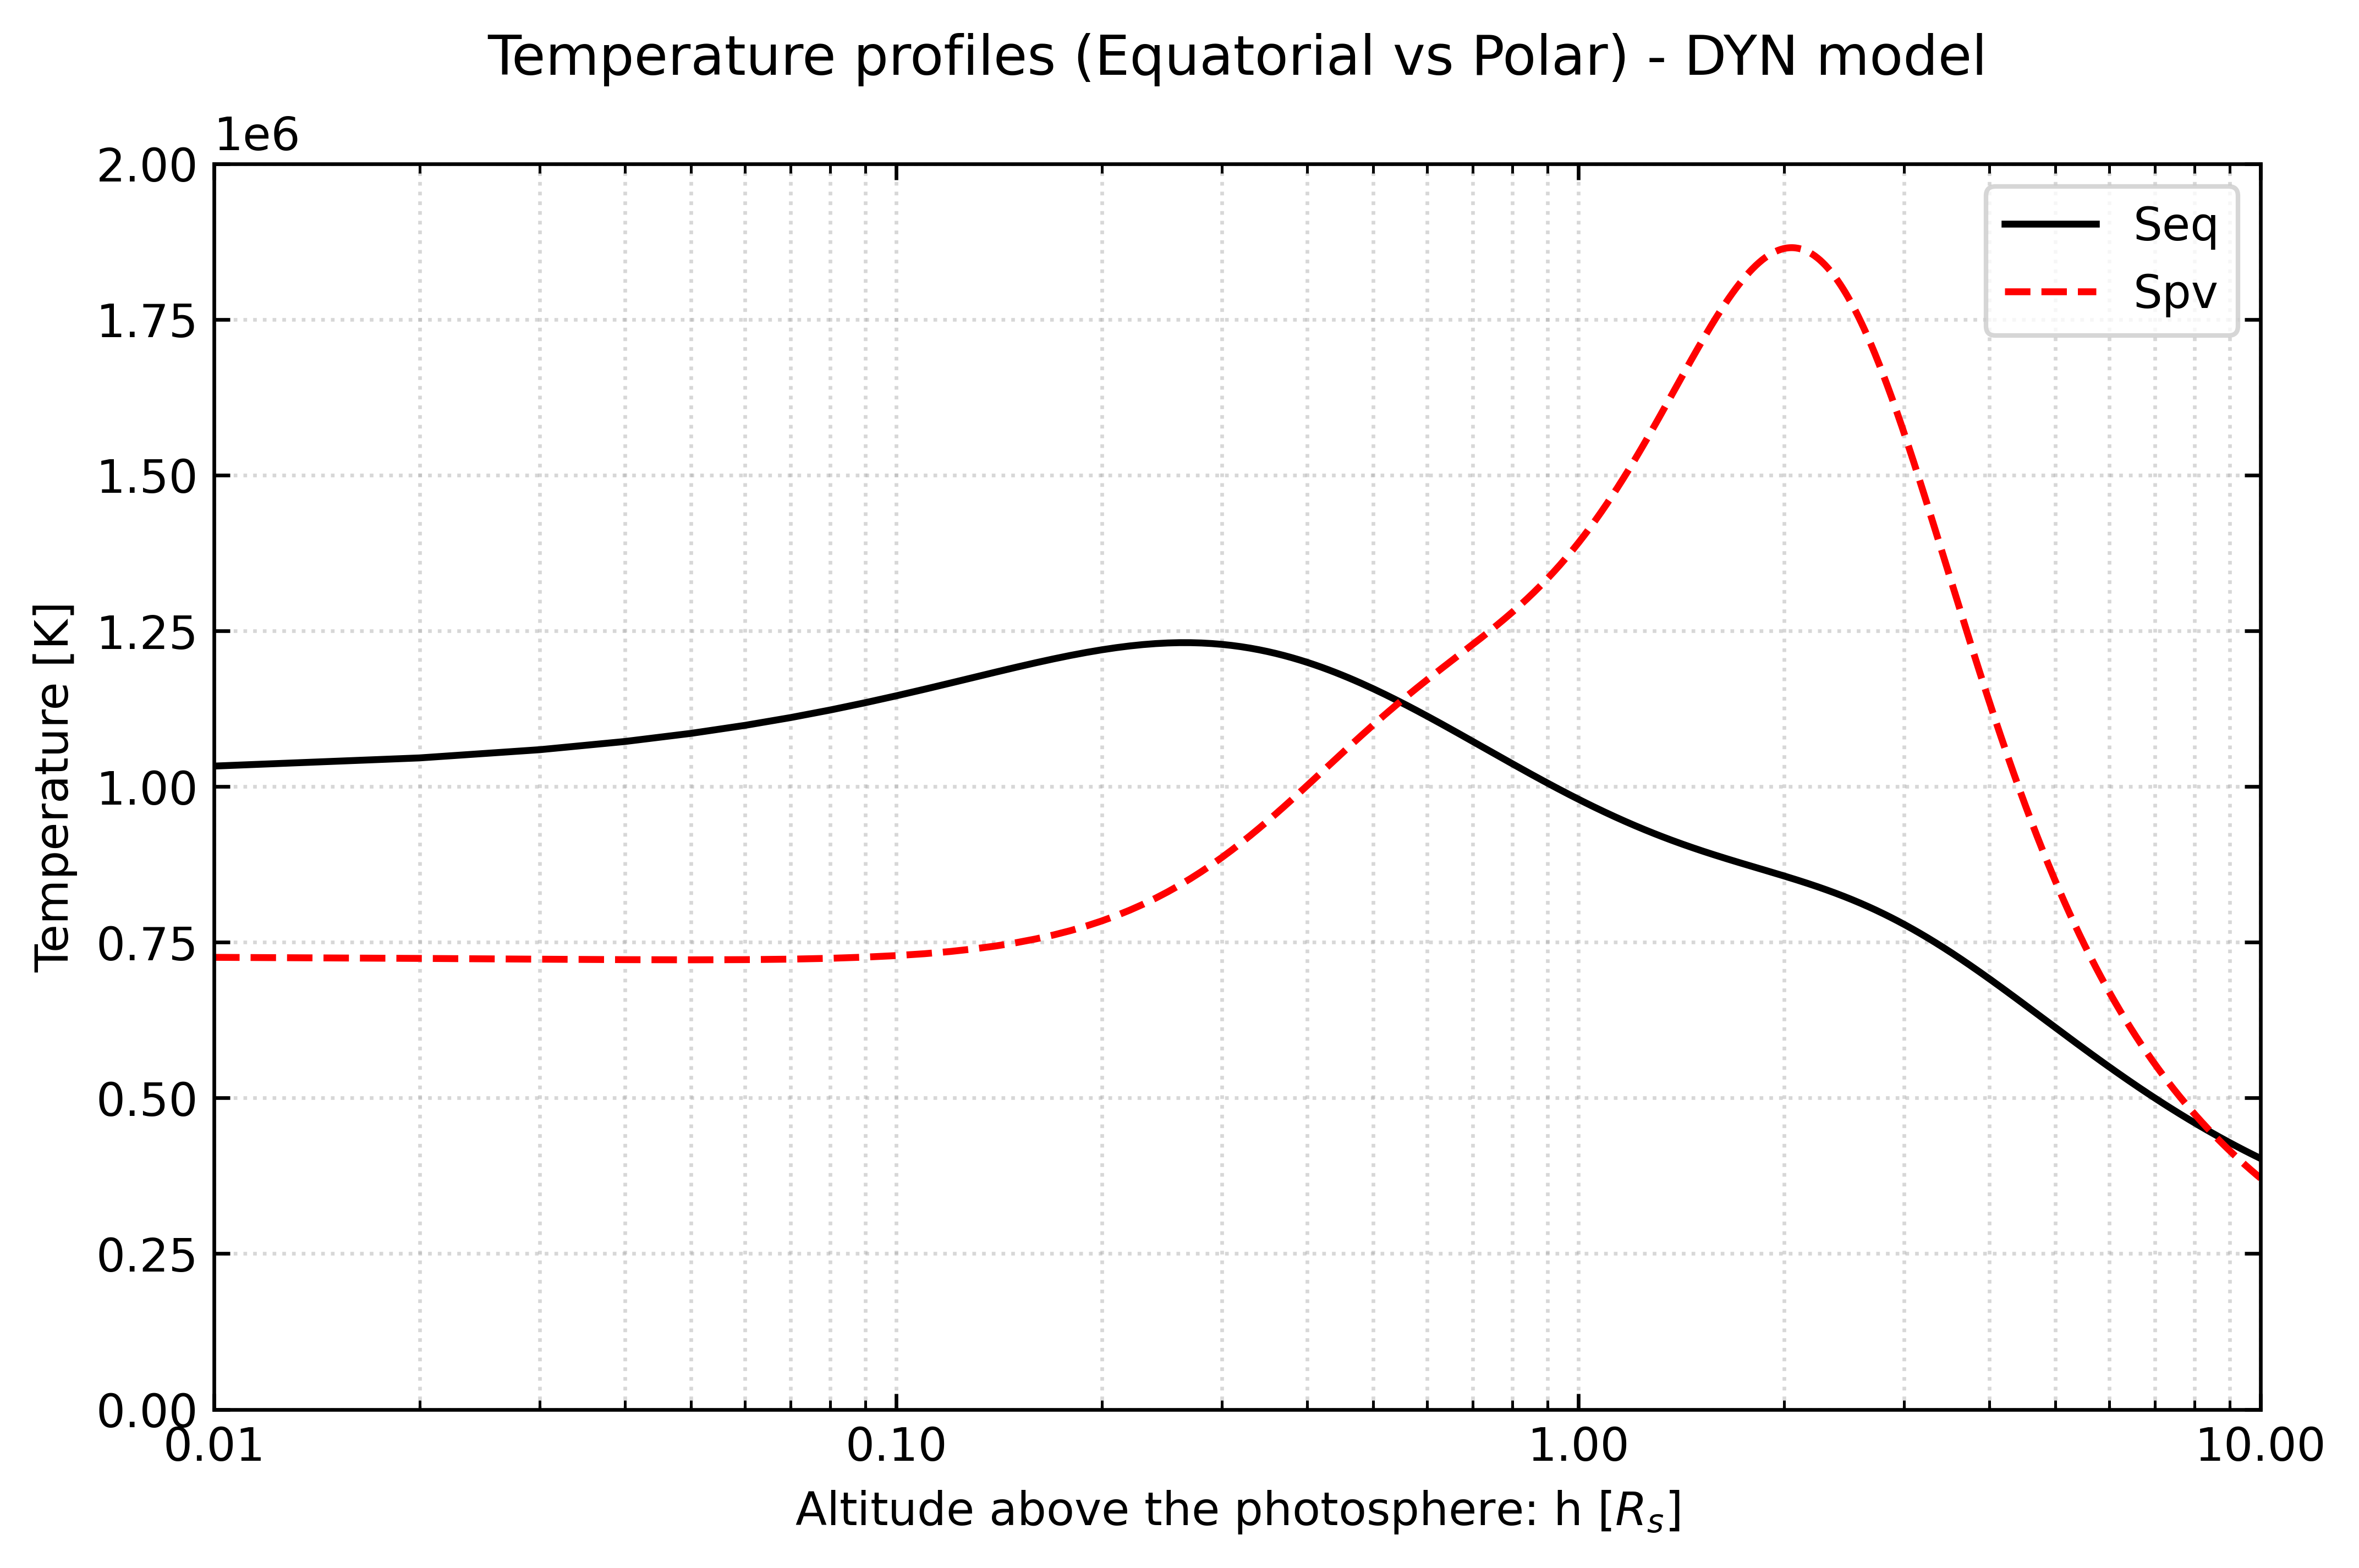

In [17]:
plt.figure(figsize=(8, 5))

# Plot
plt.plot(h_values, T_differentLat[0], "-",  label='Seq', color = "black")
plt.plot(h_values, T_differentLat[1], "--", label='Spv', color = "red")

# Cosmetic
plt.title("Temperature profiles (Equatorial vs Polar) - DYN model\n")
plt.xscale("log")
plt.xlabel("Altitude above the photosphere: h [$R_s$]")
plt.ylabel("Temperature [K]")
plt.tick_params(direction="in", which="both", top = "True", right = "True")
plt.grid(True, which="both", linestyle=":", alpha = 0.5)

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain', axis='x')

plt.xlim(0.01,10)
plt.ylim(0.00,2e6)

# Legend
plt.legend()
plt.rcParams['figure.dpi'] = 600  # set the image resolution at 600 DPI

In the following, other *equatorial* temperature profiles considering different values of nE and uE (compare with Figure 3 in \[REF_2\]): 

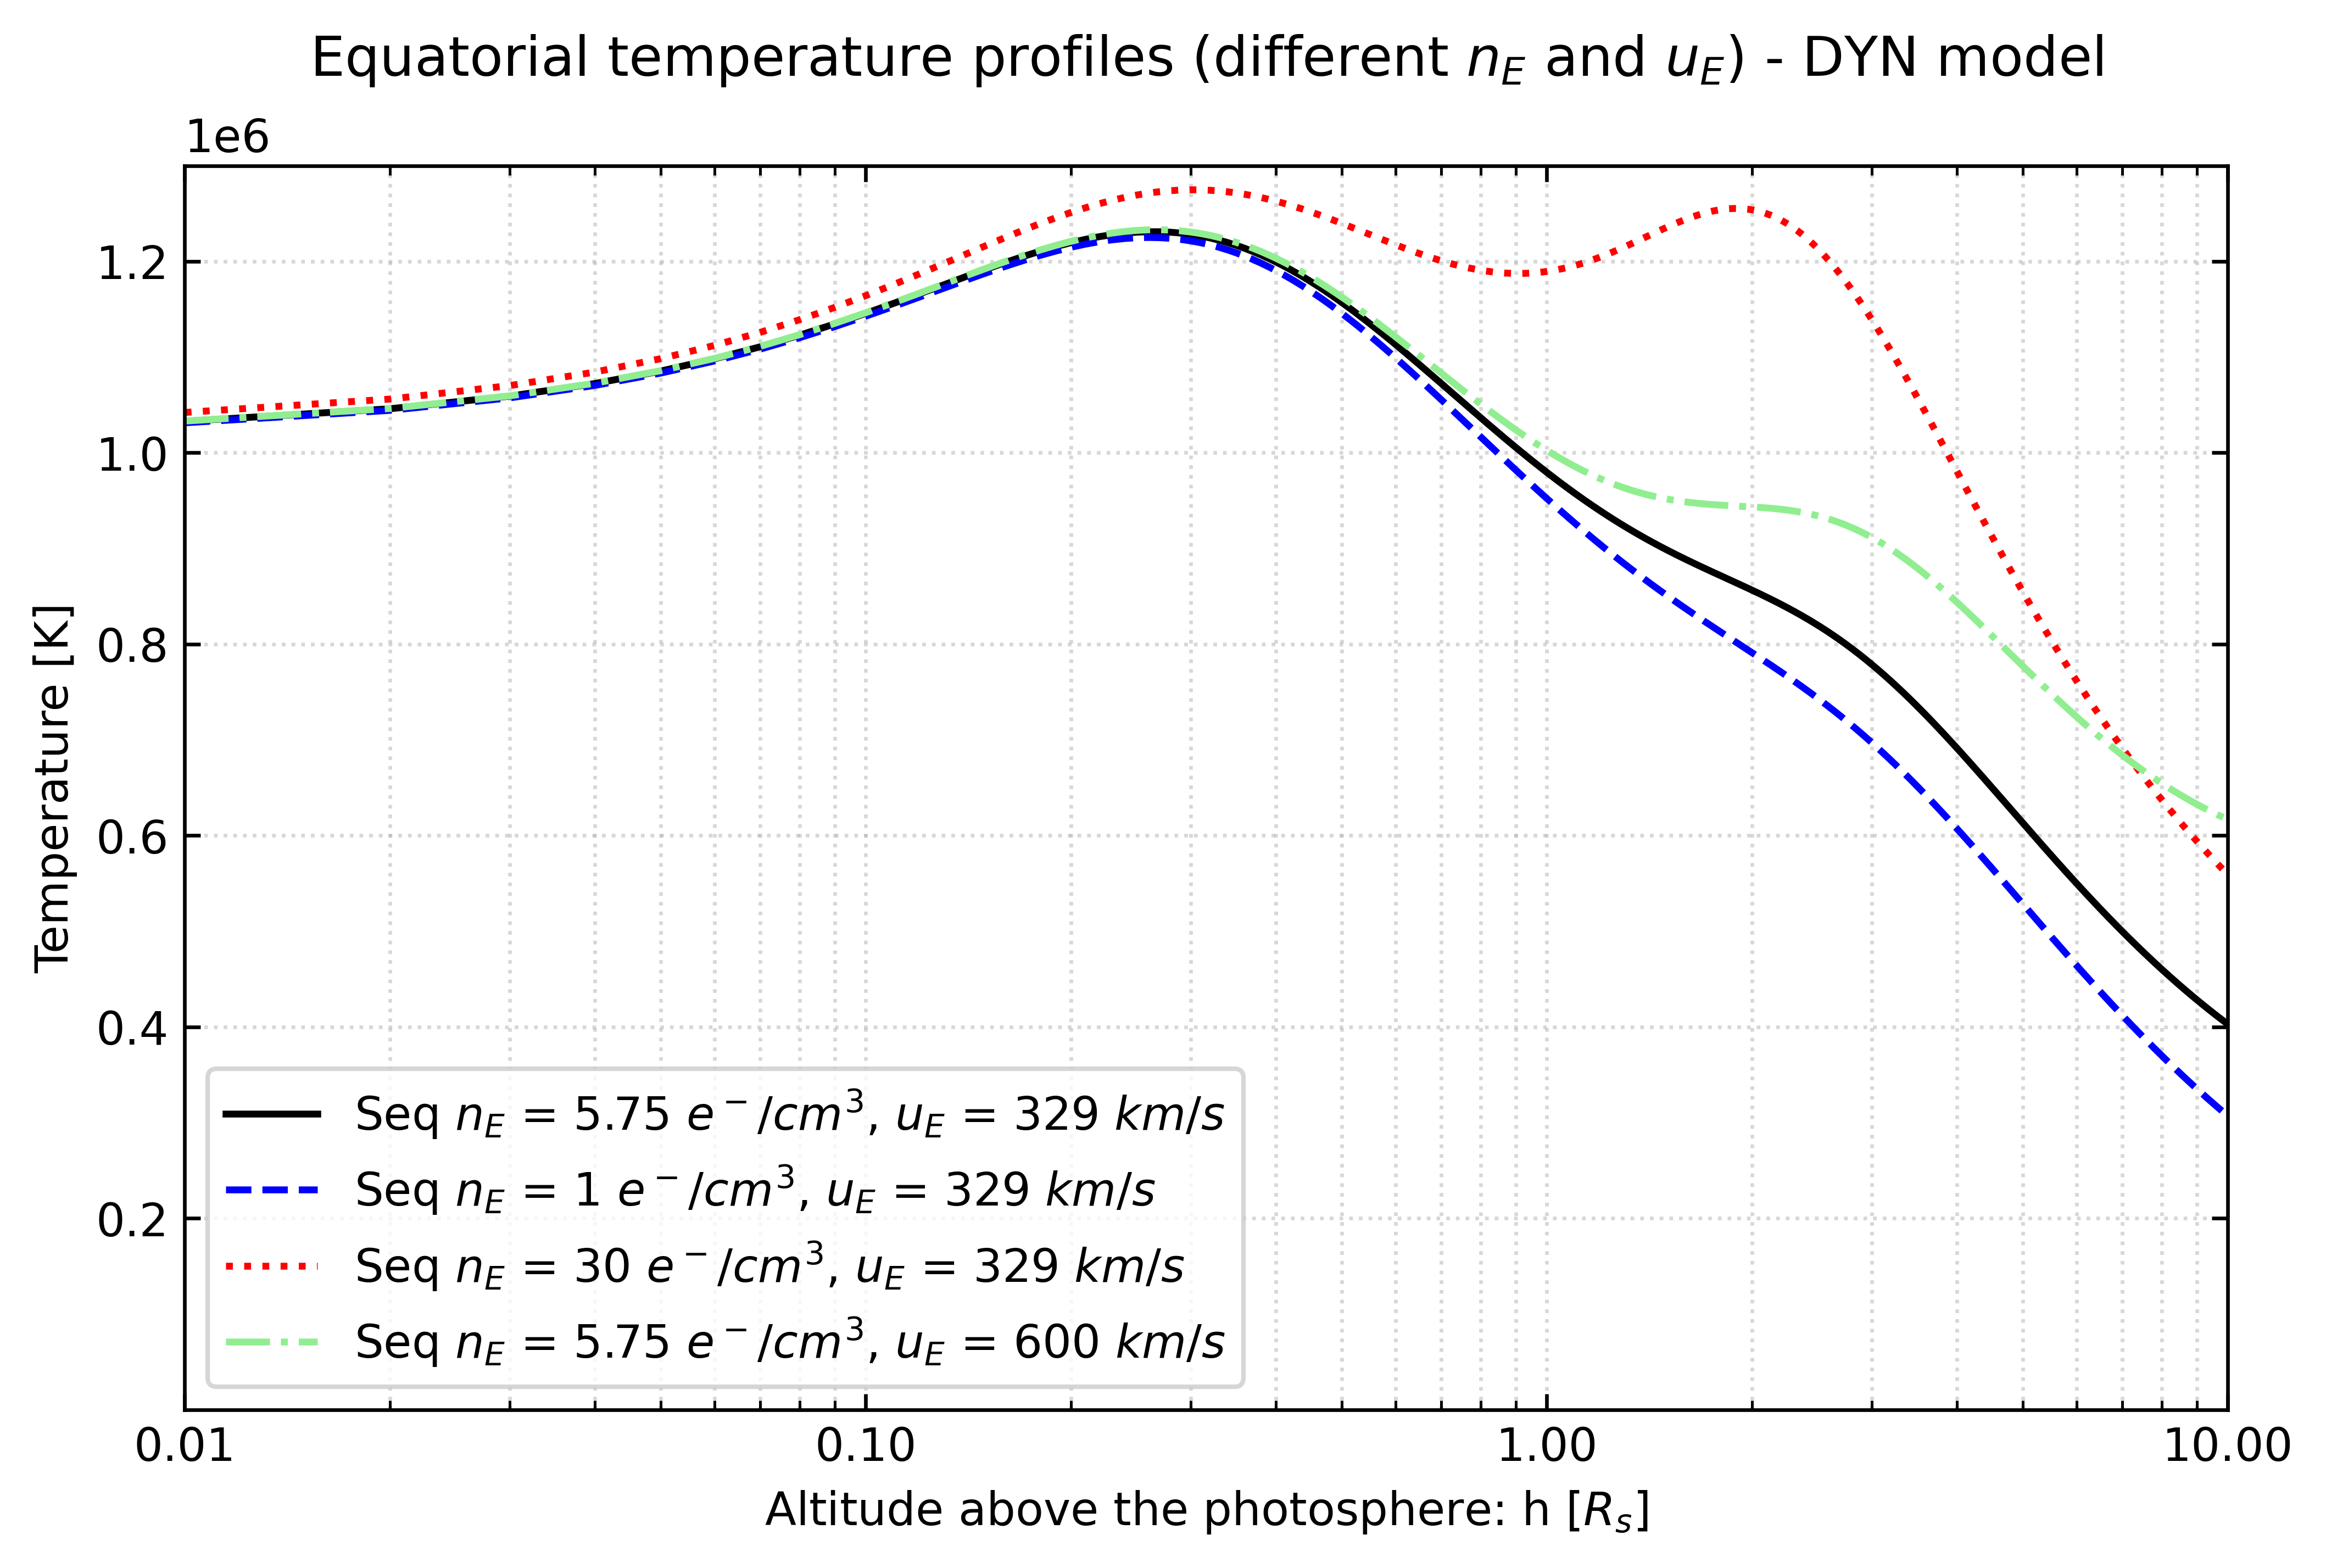

In [18]:
plt.figure(figsize=(8, 5))

# Plot
plt.plot(h_values, T_differentLat[2], "-",  label='Seq $n_E$ = {0} $e^-/cm^3$, $u_E$ = {1:.0f} $km/s$'.format(nE[2], uE[2]*10**-5), color = "black")
plt.plot(h_values, T_differentLat[3], "--", label='Seq $n_E$ = {0} $e^-/cm^3$, $u_E$ = {1:.0f} $km/s$'.format(nE[3], uE[3]*10**-5), color = "blue")
plt.plot(h_values, T_differentLat[4], ":",  label='Seq $n_E$ = {0} $e^-/cm^3$, $u_E$ = {1:.0f} $km/s$'.format(nE[4], uE[4]*10**-5), color = "red")
plt.plot(h_values, T_differentLat[5], "-.", label='Seq $n_E$ = {0} $e^-/cm^3$, $u_E$ = {1:.0f} $km/s$'.format(nE[5], uE[5]*10**-5), color = "lightgreen")

# Cosmetic
plt.title("Equatorial temperature profiles (different $n_E$ and $u_E$) - DYN model\n")
plt.xscale("log")
plt.xlabel("Altitude above the photosphere: h [$R_s$]")
plt.ylabel("Temperature [K]")
plt.tick_params(direction="in", which="both", top = "True", right = "True")
plt.grid(True, which="both", linestyle=":", alpha = 0.5)

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain', axis='x')

plt.xlim(0.01,10)
plt.ylim(0.3,1.3e6)

# Legend
plt.legend()
plt.rcParams['figure.dpi'] = 600  # set the image resolution at 600 DPI

In the following, other *polar* temperature profiles considering different values of nE and uE (compare with Figure 5 in \[REF_1\]): 

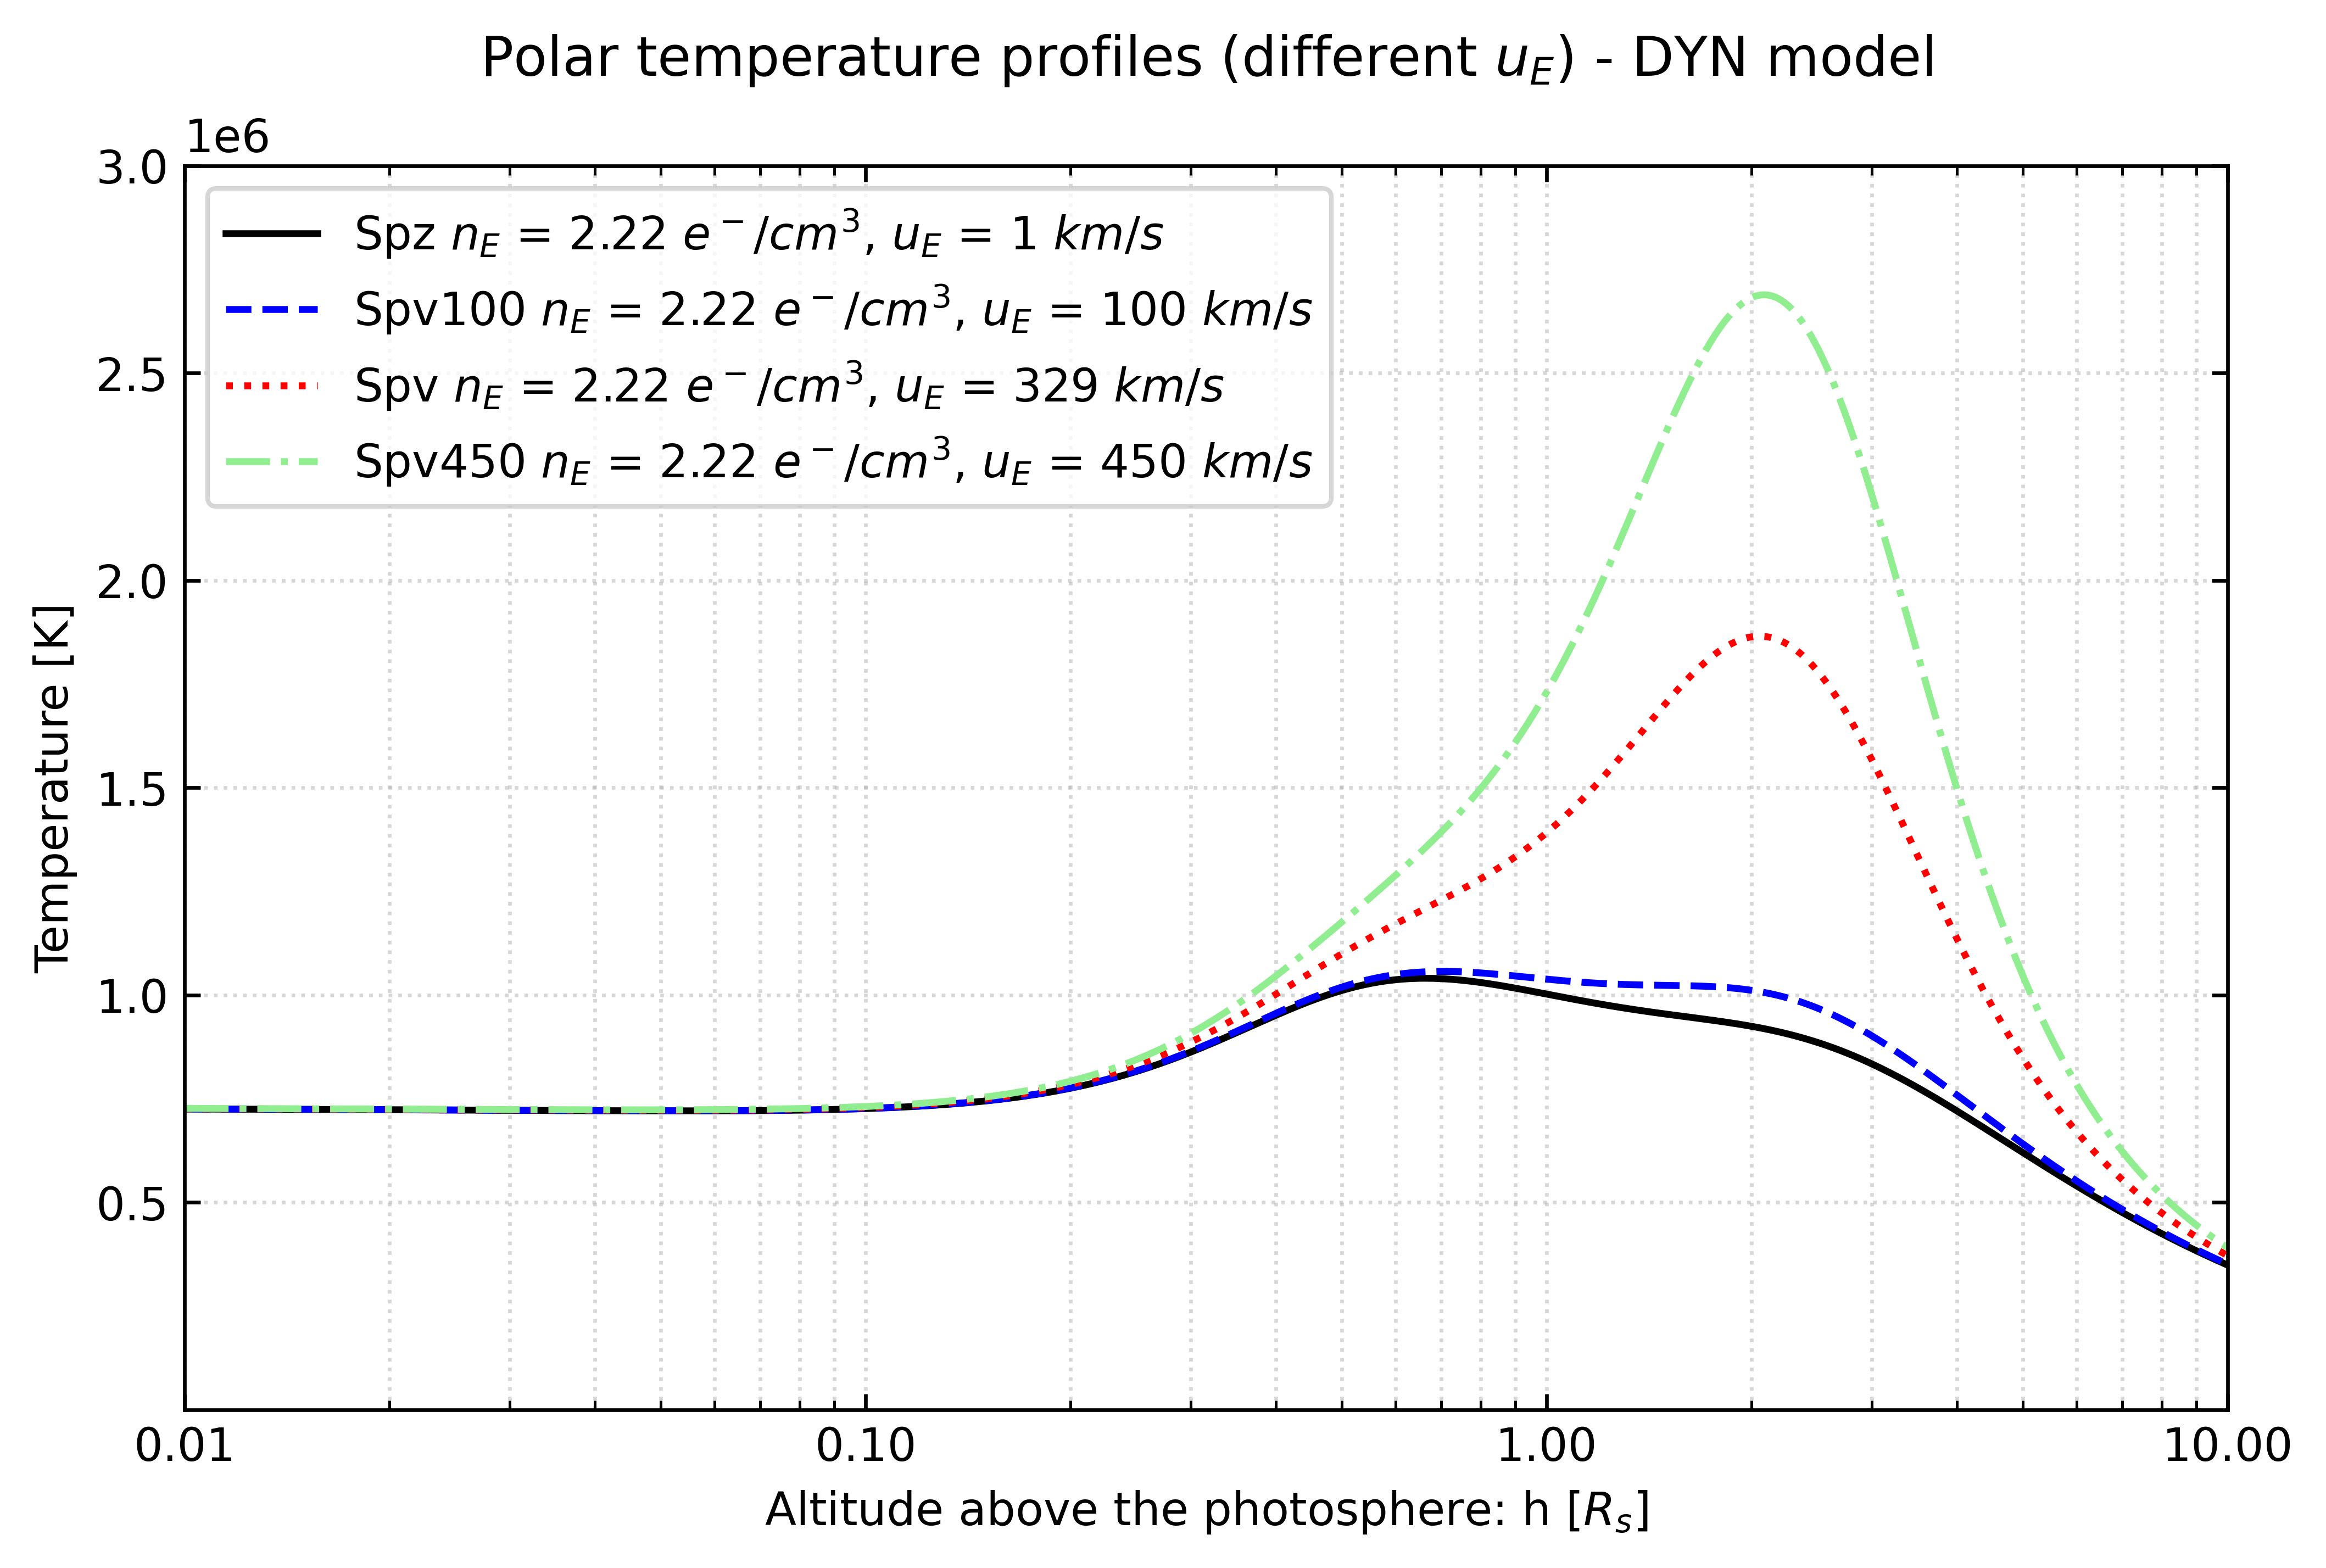

In [19]:
plt.figure(figsize=(8, 5))

# Plot
plt.plot(h_values, T_differentLat[6], "-",  label='Spz $n_E$ = {0} $e^-/cm^3$, $u_E$ = {1:.0f} $km/s$'.format(nE[6], uE[6]*10**-5), color = "black")
plt.plot(h_values, T_differentLat[7], "--", label='Spv100 $n_E$ = {0} $e^-/cm^3$, $u_E$ = {1:.0f} $km/s$'.format(nE[7], uE[7]*10**-5), color = "blue")
plt.plot(h_values, T_differentLat[8], ":",  label='Spv $n_E$ = {0} $e^-/cm^3$, $u_E$ = {1:.0f} $km/s$'.format(nE[8], uE[8]*10**-5), color = "red")
plt.plot(h_values, T_differentLat[9], "-.", label='Spv450 $n_E$ = {0} $e^-/cm^3$, $u_E$ = {1:.0f} $km/s$'.format(nE[9], uE[9]*10**-5), color = "lightgreen")

# Cosmetic
plt.title("Polar temperature profiles (different $u_E$) - DYN model\n")
plt.xscale("log")
plt.xlabel("Altitude above the photosphere: h [$R_s$]")
plt.ylabel("Temperature [K]")
plt.tick_params(direction="in", which="both", top = "True", right = "True")
plt.grid(True, which="both", linestyle=":", alpha = 0.5)

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain', axis='x')

plt.xlim(0.01,10)
plt.ylim(0.3,3.0e6)

# Legend
plt.legend(loc='upper left')
plt.rcParams['figure.dpi'] = 600  # set the image resolution at 600 DPI

In all the DYN models above it is assumed that: 

- the temperature of the coronal protons is the same as that of the electrons ($T_p /T_e = \tau_p = 1$);

- the concentration of heavier ions is equal to zero $(n_{He^{++}}/n_{H^+} = \alpha = 0)$.

However, these questionable simplifications can easily be relaxed. In the MATLAB&reg; code developed by \[REF_1\], the value of $\alpha$ and $\tau_p$ can be given different constant values which are independent of $r$. Results for such more evolved DYN models have been reported in Table 2 of \[REF_1\].

<br>

Additional comments on the DYN profiles and their properties can be found in \[REF_1\] and \[REF_2\].

---